# Autoregression 

## Parameters

In [46]:
import tensorflow as tf 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Data & Plots

In [24]:
def read_climate_dataset():
    zip_path = tf.keras.utils.get_file(
        origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
        fname='jena_climate_2009_2016.csv.zip',
        extract=True
        )

    csv_path, _ = os.path.splitext(zip_path)
    df = pd.read_csv(csv_path)

    return df 

def format_climate_dataset(df):

    df["date_time"] = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
    df["date"] = df["date_time"].dt.date
    df["period"] = df["date_time"].dt.to_period('M').dt.to_timestamp()
    
    return df 

df = read_climate_dataset()
df = format_climate_dataset(df)
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),date_time,date,period
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,2009-01-01 00:10:00,2009-01-01,2009-01-01
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,2009-01-01 00:20:00,2009-01-01,2009-01-01
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,2009-01-01 00:30:00,2009-01-01,2009-01-01
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,2009-01-01 00:40:00,2009-01-01,2009-01-01
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,2009-01-01 00:50:00,2009-01-01,2009-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,2016-12-31 23:20:00,2016-12-31,2016-12-01
420547,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,2016-12-31 23:30:00,2016-12-31,2016-12-01
420548,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,2016-12-31 23:40:00,2016-12-31,2016-12-01
420549,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8,2016-12-31 23:50:00,2016-12-31,2016-12-01


In [52]:
variable = "T (degC)"
date_variable = "period"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


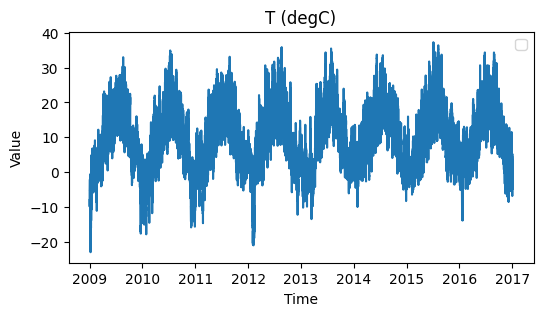

In [53]:
def plot_time_series(data, variable):

    plt.figure(figsize=(6,3))
    plt.plot(data.date_time, data[variable])
    plt.title(variable)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show() 
    
plot_time_series(df, variable)

In [54]:
# Group the values to make the analysis easier
data = df.groupby([date_variable], as_index = False)[[variable]].mean()
data

,period,T (degC)
0,2009-01-01,-3.626617
1,2009-02-01,0.169950
2,2009-03-01,3.989944
3,2009-04-01,11.889757
4,2009-05-01,13.433905
...,...,...
92,2016-09-01,17.412662
93,2016-10-01,8.695581
94,2016-11-01,3.821819
95,2016-12-01,2.003226


## Forecasting Model 

In [55]:
# Lest Create the Train and Test Data 
train_size = int(len(data[date_variable])*0.8)
train = data[:train_size].copy()
test = data[train_size:].copy()
train

,period,T (degC)
0,2009-01-01,-3.626617
1,2009-02-01,0.169950
2,2009-03-01,3.989944
3,2009-04-01,11.889757
4,2009-05-01,13.433905
...,...,...
72,2015-01-01,2.593551
73,2015-02-01,1.062059
74,2015-03-01,5.241246
75,2015-04-01,8.852567


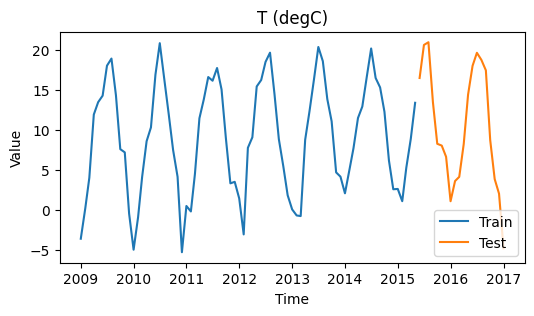

In [56]:
plt.figure(figsize=(6,3))
plt.plot(train[date_variable], train[variable], label = f'Train')
plt.plot(test[date_variable], test[variable], label = f'Test')
plt.title(f"{variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

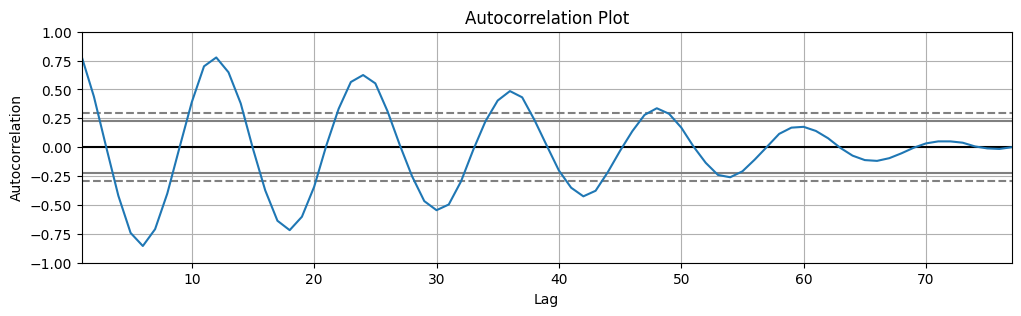

In [57]:
plt.figure(figsize = (12,3))
autocorrelation_plot(train[variable])
plt.title("Autocorrelation Plot")
plt.show()

## ARIMA 

In [77]:
# fit model
model_1 = ARIMA(train[variable], order=(10,1,0))
model_2 = ARIMA(train[variable], order=(10,2,0))
model_1_fit = model_1.fit()
model_2_fit = model_2.fit()

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                   77
Model:                ARIMA(10, 1, 0)   Log Likelihood                -165.776
Date:                Tue, 11 Jun 2024   AIC                            353.552
Time:                        00:45:01   BIC                            379.190
Sample:                             0   HQIC                           363.798
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5668      0.117     -4.840      0.000      -0.796      -0.337
ar.L2         -0.3499      0.151     -2.312      0.021      -0.646      -0.053
ar.L3         -0.1922      0.129     -1.487      0.1

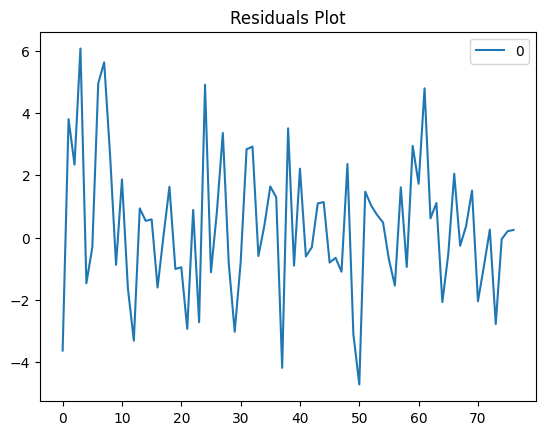

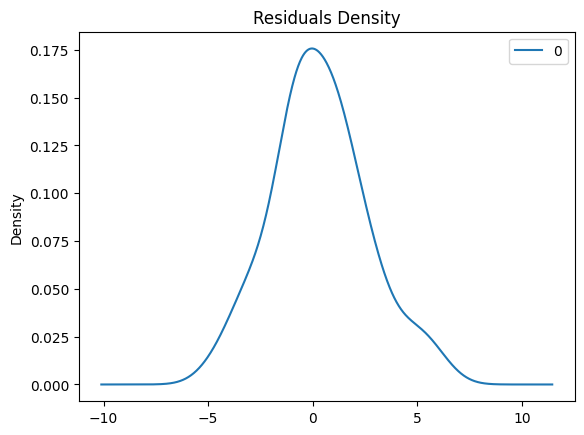

               0
count  77.000000
mean    0.343520
std     2.256900
min    -4.714640
25%    -0.943814
50%     0.253861
75%     1.631018
max     6.066734


In [78]:
# Summary of fit Model 
print(model_1_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_1_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

In [81]:
train["prediction_order_1"] = model_1_fit.predict(start=0, end=len(train))
train["prediction_order_2"] = model_2_fit.predict(start=0, end=len(train))

test["prediction_order_1"] = model_1_fit.forecast(steps = len(test))
test["prediction_order_2"] = model_2_fit.forecast(steps = len(test))
test

,period,T (degC),prediction_order_1,prediction_order_2
77,2015-06-01,16.455951,17.652448,17.554935
78,2015-07-01,20.586064,17.886529,17.782398
79,2015-08-01,20.926499,18.048330,18.394618
80,2015-09-01,13.438380,15.665300,15.848130
81,2015-10-01,8.234736,11.074502,11.418155
82,2015-11-01,8.009806,6.545242,7.440818
83,2015-12-01,6.612672,3.851351,4.940327
84,2016-01-01,1.058154,1.544736,2.841971
85,2016-02-01,3.580045,2.282368,3.920861
86,2016-03-01,4.102914,4.837615,6.400966


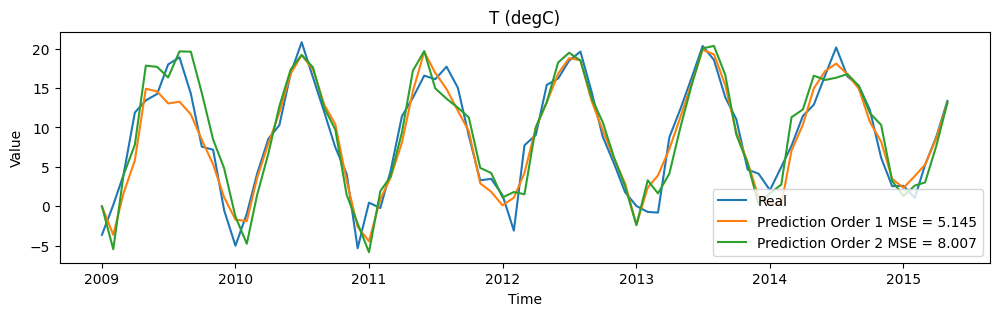

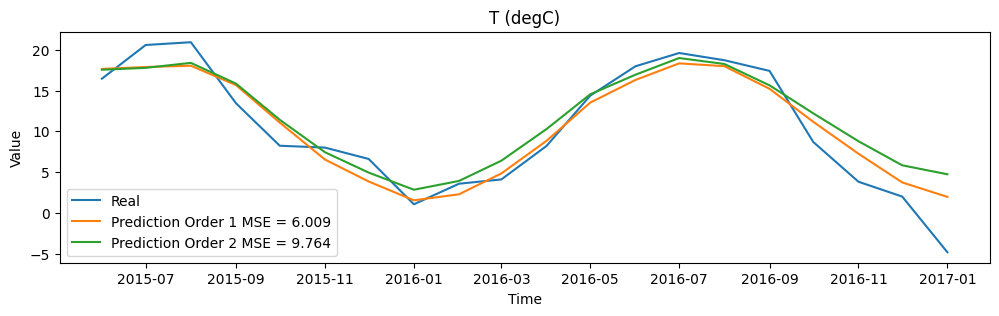

In [82]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[variable], label = f'Real')
plt.plot(train[date_variable], train["prediction_order_1"], label = f"Prediction Order 1 MSE = {round(mean_squared_error(train[variable], train['prediction_order_1']),3)}")
plt.plot(train[date_variable], train["prediction_order_2"], label = f"Prediction Order 2 MSE = {round(mean_squared_error(train[variable], train['prediction_order_2']),3)}")
plt.title(f"{variable} TRAIN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[variable], label = f'Real')
plt.plot(test[date_variable], test["prediction_order_1"], label = f"Prediction Order 1 MSE = {round(mean_squared_error(test[variable], test['prediction_order_1']),3)}")
plt.plot(test[date_variable], test["prediction_order_2"], label = f"Prediction Order 2 MSE = {round(mean_squared_error(test[variable], test['prediction_order_2']),3)}")
plt.title(f"{variable} TEST")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 